In [76]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,RandomFlip, RandomRotation, RandomZoom, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from numpy import random, arange, unique
# %load_ext tensorboard

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [9]:
DATA_PATH = os.path.join('/kaggle/input/vegetable-image-dataset/Vegetable Images')
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VAL_PATH = os.path.join(DATA_PATH, "validation")
TEST_PATH = os.path.join(DATA_PATH, "test")

In [5]:
strategy = tf.distribute.MirroredStrategy()

In [6]:
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
IMG_SHAPE = [224, 224]
SEED = 42

In [10]:
CLASS_INDICES = {i: j for j, i in enumerate(os.listdir(TRAIN_PATH))}
CLASS_INDICES

{'Broccoli': 0,
 'Capsicum': 1,
 'Bottle_Gourd': 2,
 'Radish': 3,
 'Tomato': 4,
 'Brinjal': 5,
 'Pumpkin': 6,
 'Carrot': 7,
 'Papaya': 8,
 'Cabbage': 9,
 'Bitter_Gourd': 10,
 'Cauliflower': 11,
 'Bean': 12,
 'Cucumber': 13,
 'Potato': 14}

In [11]:
# IMAGE AUGMENTATION
image_augmentation = Sequential()
image_augmentation.add(RandomFlip(seed=42))
image_augmentation.add(RandomRotation(factor=(-0.5, 0.5), seed=SEED))
image_augmentation.add(RandomZoom(height_factor = (-0.4, 0.2), width_factor=(-0.4, 0.2)))

In [12]:
training_data = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    seed=SEED,
    class_names=CLASS_INDICES.keys(),
    image_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
)
training_data = training_data.map(lambda img, label: (image_augmentation(img), label), num_parallel_calls=tf.data.AUTOTUNE)

Found 15000 files belonging to 15 classes.


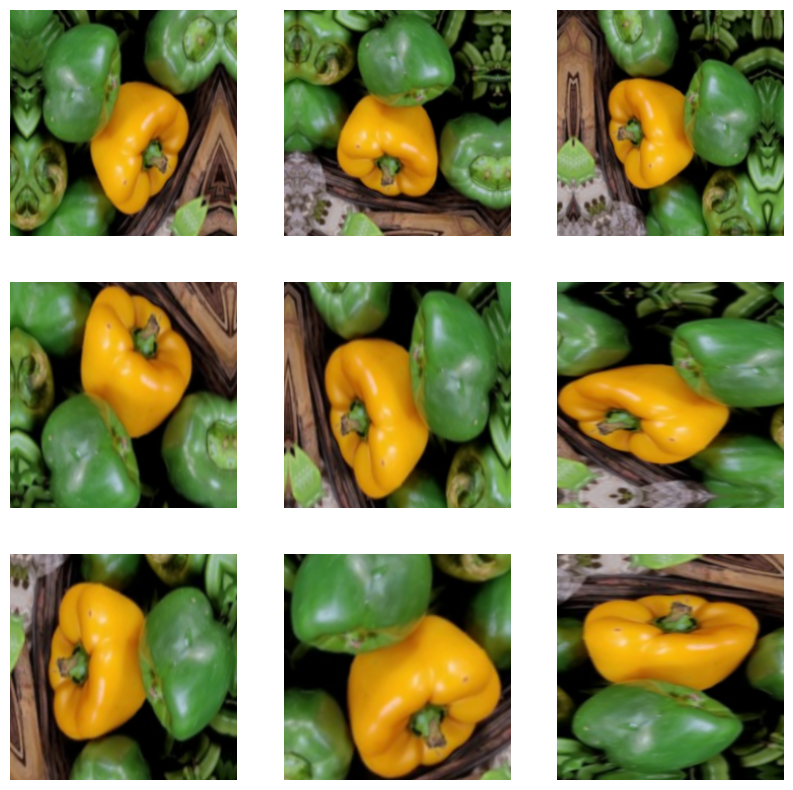

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in training_data.take(1):
    for i in range(9):
        augmented_images = image_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [14]:
training_data = training_data.map(lambda img, label: (image_augmentation(img), label), num_parallel_calls=tf.data.AUTOTUNE)
training_data = training_data.map(lambda img, label: (preprocess_input(img), label), num_parallel_calls=tf.data.AUTOTUNE)
training_data = training_data.prefetch(tf.data.AUTOTUNE)
training_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [15]:
val_data = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    seed=SEED,
    class_names=CLASS_INDICES.keys(),
    image_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
)
val_data = val_data.map(lambda img, label: (image_augmentation(img), label), num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(lambda img, label: (preprocess_input(img), label), num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.prefetch(tf.data.AUTOTUNE)
val_data

Found 3000 files belonging to 15 classes.


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
test_data = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    seed=SEED,
    class_names=CLASS_INDICES.keys(),
    image_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
)
test_data = test_data.map(lambda img, label: (image_augmentation(img), label), num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(lambda img, label: (preprocess_input(img), label), num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)
test_data

Found 3000 files belonging to 15 classes.


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
N_CLASSES = len(CLASS_INDICES)
N_CLASSES

15

In [20]:
with strategy.scope():
  vgg = MobileNetV2(input_shape=IMG_SHAPE + [3], classes=N_CLASSES, include_top=False)
  for layer in vgg.layers[:-2]:
      layer.trainable = False

  top = vgg.output
  top = Flatten()(top)
  top = Dense(units=50, activation="relu")(top)
  top = Dropout(0.3)(top)
  top = Dense(units=40, activation="relu")(top)
  top = Dense(units=N_CLASSES, activation="softmax")(top)

  model = Model(inputs=vgg.input, outputs=top)

  model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])

9406464/9406464 [==============================] - 0s 0us/step


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [21]:
early_stop = EarlyStopping(monitor="val_loss",patience=4,mode="min") #Ensure the model doesn't overfit

In [22]:
random.seed(SEED)
set_seed(SEED)
np.random.seed(SEED)

history = model.fit(training_data,batch_size=BATCH_SIZE,epochs=500,callbacks=[early_stop],validation_data=val_data)

Epoch 1/500
235/235 [==============================] - 381s 2s/step - loss: 1.1261 - sparse_categorical_accuracy: 0.6252 - val_loss: 0.2368 - val_sparse_categorical_accuracy: 0.9280
Epoch 2/500
235/235 [==============================] - 324s 1s/step - loss: 0.7218 - sparse_categorical_accuracy: 0.7571 - val_loss: 0.1401 - val_sparse_categorical_accuracy: 0.9600
Epoch 3/500
235/235 [==============================] - 331s 1s/step - loss: 0.6478 - sparse_categorical_accuracy: 0.7805 - val_loss: 0.1150 - val_sparse_categorical_accuracy: 0.9667
Epoch 4/500
235/235 [==============================] - 330s 1s/step - loss: 0.5773 - sparse_categorical_accuracy: 0.8087 - val_loss: 0.1120 - val_sparse_categorical_accuracy: 0.9667
Epoch 5/500
235/235 [==============================] - 342s 1s/step - loss: 0.5409 - sparse_categorical_accuracy: 0.8162 - val_loss: 0.0986 - val_sparse_categorical_accuracy: 0.9710
Epoch 6/500
235/235 [==============================] - 327s 1s/step - loss: 0.5430 - spars

In [24]:
loss_df = pd.DataFrame(history.history)
loss_df

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,1.126067,0.625200,0.236814,0.928000
1,0.721804,0.757133,0.140150,0.960000
2,0.647771,0.780467,0.115010,0.966667
3,0.577321,0.808667,0.111995,0.966667
4,0.540894,0.816200,0.098625,0.971000
5,0.542993,0.822000,0.090077,0.973667
6,0.508885,0.839933,0.078270,0.978667
7,0.476487,0.848467,0.072341,0.975667
8,0.455484,0.850200,0.055943,0.985000
9,0.448442,0.857800,0.062169,0.984000


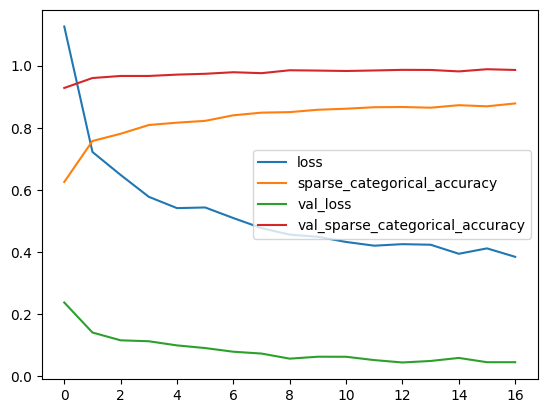

In [25]:
loss_df.plot();

In [26]:
model.evaluate(test_data)

47/47 [==============================] - 39s 711ms/step - loss: 0.0478 - sparse_categorical_accuracy: 0.9847


[0.04775300994515419, 0.984666645526886]

MODEL QUANTIZATION

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

SAVING TFLITE MODEL

In [28]:
import pathlib

tflite_models_dir = pathlib.Path(os.path.join("kaggle", "working", "vegetable_classification_models"))
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"vegetable_classification_model_mnet_2.tflite"
tflite_model_file.write_bytes(tflite_model)

21413256

TFLITE MODEL INFERENCE

In [29]:
import tensorflow.lite as lite
import os
from matplotlib.pyplot import imread
from numpy import expand_dims
from tensorflow.keras.utils import load_img, save_img, img_to_array

In [30]:
interpreter = tf.lite.Interpreter(model_path=os.path.join("kaggle", "working", "vegetable_classification_models", "vegetable_classification_model_mnet_2.tflite"))

In [31]:
def predict(test_image):
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    test_image = test_image.astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    prediction = [*CLASS_INDICES.keys()][output.argmax()]
    probability = round(output.max() * 100, 2)
    result = f'{prediction} ({probability}%)'
    return result

In [59]:
CLASS_INDICES = {'Broccoli': 0,
 'Capsicum': 1,
 'Bottle_Gourd': 2,
 'Radish': 3,
 'Tomato': 4,
 'Brinjal': 5,
 'Pumpkin': 6,
 'Carrot': 7,
 'Papaya': 8,
 'Cabbage': 9,
 'Bitter_Gourd': 10,
 'Cauliflower': 11,
 'Bean': 12,
 'Cucumber': 13,
 'Potato': 14}
DATA_PATH = os.path.join("/", 'kaggle', 'input', 'vegetable-image-dataset', 'Vegetable Images')
TEST_PATH = os.path.join(DATA_PATH, "test")

In [38]:
def inference(img_path: str):
    test_image = load_img(img_path, color_mode="rgb", target_size=(224, 224))
    test_image = img_to_array(test_image)
    test_image = preprocess_input(test_image)
    test_image = np.array([test_image])
    return predict(test_image)

In [60]:
inference(os.path.join(TEST_PATH, "Bitter_Gourd", "1201.jpg"))

'Bitter_Gourd (100.0%)'

In [61]:
inference(os.path.join(TEST_PATH, "Bean", "0102.jpg"))

'Bean (82.84%)'

In [62]:
inference(os.path.join(TEST_PATH, "Bottle_Gourd", "1018.jpg"))

'Bottle_Gourd (99.99%)'

In [63]:
inference(os.path.join(TEST_PATH, "Brinjal", "1008.jpg"))

'Brinjal (99.35%)'

In [64]:
inference(os.path.join(TEST_PATH, "Broccoli", "1015.jpg"))

'Broccoli (100.0%)'

In [65]:
inference(os.path.join(TEST_PATH, "Cabbage", "1008.jpg"))

'Cabbage (99.99%)'

In [66]:
inference(os.path.join(TEST_PATH, "Capsicum", "1010.jpg"))

'Capsicum (99.6%)'

In [67]:
inference(os.path.join(TEST_PATH, "Carrot", "1019.jpg"))

'Carrot (100.0%)'

In [68]:
inference(os.path.join(TEST_PATH, "Cauliflower", "1054.jpg"))

'Cauliflower (100.0%)'

In [69]:
inference(os.path.join(TEST_PATH, "Cucumber", "1011.jpg"))

'Cucumber (100.0%)'

In [70]:
inference(os.path.join(TEST_PATH, "Papaya", "1205.jpg"))

'Papaya (96.63%)'

In [71]:
inference(os.path.join(TEST_PATH, "Potato", "1011.jpg"))

'Potato (99.93%)'

In [73]:
inference(os.path.join(TEST_PATH, "Pumpkin", "1001.jpg"))

'Pumpkin (100.0%)'

In [74]:
inference(os.path.join(TEST_PATH, "Radish", "1008.jpg"))

'Radish (100.0%)'

In [75]:
inference(os.path.join(TEST_PATH, "Tomato", "1008.jpg"))

'Tomato (92.72%)'